<a href="https://colab.research.google.com/github/gatienc/multimodal_product_data_classification/blob/main/notebooks/gatien_fusion_model_clip0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Idea
idea use clip to obtain features

# Hyperparameters

In [135]:
BATCH_SIZE=250#  8 for 13.8 gb usage, 6 for less than 12 gb usage
NUM_CLASSES=27

CLIP_FEATURE_SIZE=768

#testing
train_percentage=0.001
valid_percentage=0.001

# train_percentage=0.9
# valid_percentage=0.1
#(test_percentage takes the rest)

google_colab=False

# Imports


In [136]:
%pip install transformers pandas tqdm scikit-learn imageio matplotlib wget

Note: you may need to restart the kernel to use updated packages.


In [137]:
from transformers import CLIPProcessor, CLIPModel,CLIPFeatureExtractor
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler
import torchvision

import imageio

from tqdm.auto import tqdm # for cool loading bar
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import f1_score

import zipfile
import os
import copy

import matplotlib.pyplot as plt

from datetime import datetime


In [138]:
if google_colab:
  # mount the drive where your dataset is availabledevice = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  from google.colab import drive
  drive.mount('/content/drive')
  filepath='/content/drive/MyDrive/datasets/multimodal_product_classification/' # add your own path. Where to save the dataset

  if not os.path.exists('datasets'):
    os.makedirs('datasets')
    with zipfile.ZipFile(filepath+'images.zip', 'r') as zip_ref:
        zip_ref.extractall('datasets')
else:
  import wget
  if not os.path.exists('datasets'):
    os.makedirs('datasets')
    output_directory="datasets"
    csv_zip = wget.download("https://nextcloud.its-tps.fr/s/BTpB4SC93NreZxg/download/csv_data.zip",out=output_directory)
    images_zip=wget.download("https://nextcloud.its-tps.fr/s/fgBxQczEAZ7ws8J/download/images.zip",out=output_directory)
    
    with zipfile.ZipFile(output_directory+'/csv_data.zip', 'r') as zip_ref:
      zip_ref.extractall('datasets')
    with zipfile.ZipFile(output_directory+'/images.zip', 'r') as zip_ref:
        zip_ref.extractall('datasets')
  filepath=os.getcwd()+'/datasets/'

In [139]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Preprocessing

In [140]:
# Load data
X_train = pd.read_csv(filepath+'X_train.csv').fillna("")
y_train = pd.read_csv(filepath+'Y_train.csv').fillna("")
X_train=X_train.drop(columns="Unnamed: 0")
y_train=y_train.drop(columns="Unnamed: 0")


In [141]:
description_len=[len(x) for x in X_train['description'].tolist()]

(array([7.4796e+04, 8.1160e+03, 1.3860e+03, 3.5100e+02, 1.6100e+02,
        6.5000e+01, 2.5000e+01, 1.3000e+01, 2.0000e+00, 1.0000e+00]),
 array([    0. ,  1245.1,  2490.2,  3735.3,  4980.4,  6225.5,  7470.6,
         8715.7,  9960.8, 11205.9, 12451. ]),
 <BarContainer object of 10 artists>)

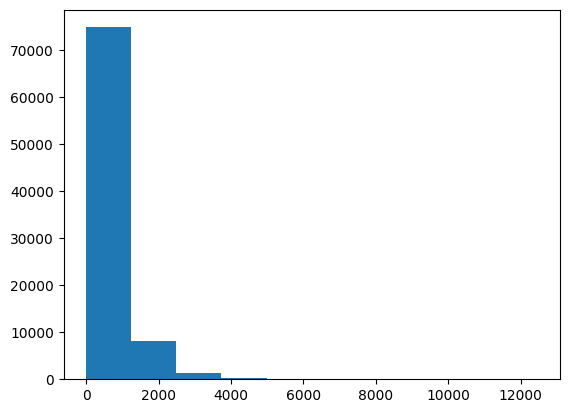

In [142]:
plt.hist(description_len)

Most of description have less than 4000 len,
maybe in the future  slice at 4000 for not too long tokenization

In [143]:
# Apply cleaning function to the 'designation' column
def clip_to_max_tokenize(text):
    text.split(" ",maxsplit=70)
    text=text[:70]
    text="".join(text)
    return(text)

X_train['designation'] = X_train['designation'].fillna('').apply(clip_to_max_tokenize)
X_train['description'] = X_train['description'].fillna('').apply(clip_to_max_tokenize)


In [169]:
encoded_df=pd.get_dummies(y_train, columns=['prdtypecode'])
y_train_categorical = encoded_df.values.tolist()


In [170]:
length=len(y_train_categorical)
y_train=pd.DataFrame(np.zeros((length,1),dtype=list),columns=["labels"])
for index,row in tqdm(enumerate(y_train_categorical)):
    y_train.loc[index, "labels"]=row
y_train

0it [00:00, ?it/s]

,labels
0,"[True, False, False, False, False, False, Fals..."
1,"[False, False, False, False, False, False, Fal..."
2,"[False, False, True, False, False, False, Fals..."
3,"[False, False, False, False, False, False, Fal..."
4,"[False, False, False, False, False, False, Fal..."
...,...
84911,"[False, True, False, False, False, False, Fals..."
84912,"[False, False, False, False, False, False, Fal..."
84913,"[False, False, False, False, False, False, Fal..."
84914,"[False, False, False, False, False, False, Fal..."


In [171]:
train_df=pd.concat([X_train,y_train],axis=1)

In [172]:
train_df

,designation,description,productid,imageid,labels
0,Olivia: Personalisiertes Notizbuch / 150 Seite...,,3804725264,1263597046,"[True, False, False, False, False, False, Fals..."
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,,436067568,1008141237,"[False, False, False, False, False, False, Fal..."
2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978,"[False, False, True, False, False, False, Fals..."
3,Peluche Donald - Europe - Disneyland 2000 (Mar...,,50418756,457047496,"[False, False, False, False, False, False, Fal..."
4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,278535884,1077757786,"[False, False, False, False, False, False, Fal..."
...,...,...,...,...,...
84911,The Sims [ Import Anglais ],,206719094,941495734,"[False, True, False, False, False, False, Fals..."
84912,Kit piscine acier NEVADA déco pierre Ø 3.50m x...,<b>Description complète :</b><br />Kit piscine...,3065095706,1188462883,"[False, False, False, False, False, False, Fal..."
84913,Journal Officiel De La Republique Francaise N°...,,440707564,1009325617,"[False, False, False, False, False, False, Fal..."
84914,Table Basse Bois De Récupération Massif Base B...,<p>Cette table basse a un design unique et con...,3942400296,1267353403,"[False, False, False, False, False, False, Fal..."



# Data loading

In [173]:
def image_to_tensor(image):
    img=torch.from_numpy(image).float()
    out=img.permute(2,0,1)
    return(out)

In [174]:
class ImageTextDataLoader(Dataset):
    """Title, Description and Image dataset."""

    def __init__(self, dataframe, image_dir):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            image_dir (string): Directory with all the images.
        """
        self.df = dataframe
        self.image_dir = image_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        selected_df=self.df.iloc[idx]

        image_name="image_"+str(selected_df["imageid"])+"_product_"+str(selected_df["productid"])+".jpg"
        filepath=os.path.join(self.image_dir,image_name)
        image_arr = imageio.v3.imread(filepath)

        designation=selected_df['designation']
        description=selected_df['description']
        label=selected_df['labels']

        return [designation,description,image_arr,label]


In [175]:
dataset=ImageTextDataLoader(train_df,"/content/datasets/images/image_train")


In [176]:
train_size = int(train_percentage * len(dataset))
valid_size = int(valid_percentage * len(dataset))
test_size = len(dataset) - train_size - valid_size

train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size, test_size])
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)


dataloaders={
    'train':train_dataloader,
    'val':valid_dataloader,
    'test':test_dataloader
    }


In [177]:
Clip_model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14").to(device)
Clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [178]:
def get_images_features(images):
    inputs = Clip_processor(images=images, return_tensors="pt").to(device)
    image_features = Clip_model.get_image_features(**inputs).to(device)
    del inputs
    return(image_features)

def get_text_features(texts):
    inputs = Clip_processor(text=texts, padding=True, return_tensors="pt").to(device)
    text_features = Clip_model.get_text_features(**inputs).to(device)
    del inputs
    return(text_features)

# Model Definition

way 0 : concat the layer
way 1 (future): cross modal concatenation

In [179]:
print(Clip_model.device)

cuda:0


In [180]:
class ClassificationHead(nn.Module):
   def __init__(self, input_dim, num_classes):
       super(ClassificationHead, self).__init__()

       self.head=nn.Sequential(
            nn.Linear(input_dim,128),
            nn.ReLU(),
            nn.Linear(128,num_classes),
       )
       #self.softmax = nn.Softmax(dim=-1)

   def forward(self, x):
       x = self.head(x)
       return (x)


In [181]:
model=ClassificationHead(3*CLIP_FEATURE_SIZE,NUM_CLASSES).to(device)

criterion = torch.nn.CrossEntropyLoss()

# All parameters are being optimized
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


In [182]:
def calculate_weighted_f1_score(y_true, y_pred):
  return f1_score(y_true, y_pred, average='weighted')

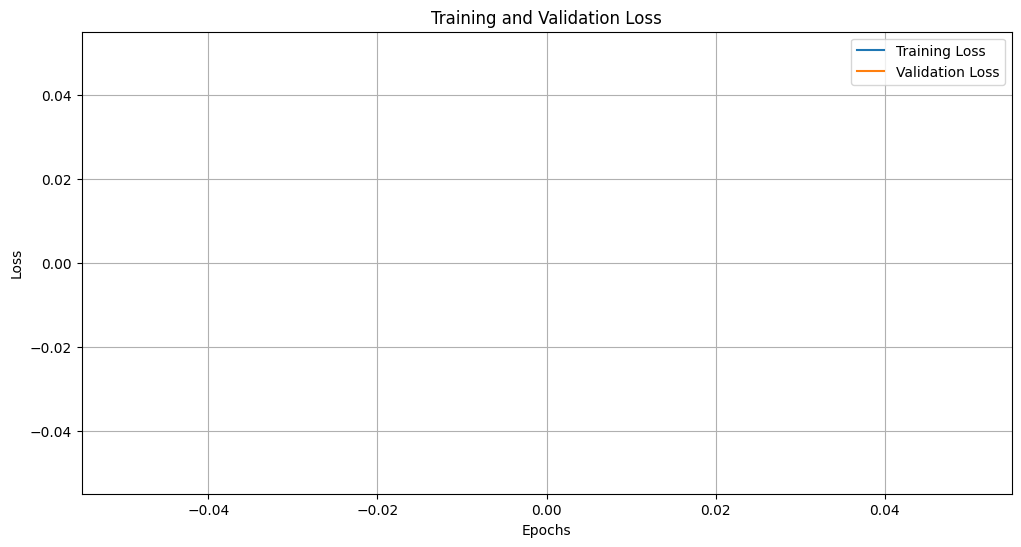

In [183]:

plt.ion()
fig = plt.figure(1,figsize=(12, 6))
ax = fig.add_subplot(111)
train_loss_line, = ax.plot([], label='Training Loss')
val_loss_line, = ax.plot([], label='Validation Loss')
ax.set_title('Training and Validation Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
ax.grid(True)

def plot_loss(train_losses,val_losses):
    train_loss_line.set_ydata(train_losses)
    val_loss_line.set_ydata(val_losses)
    fig.canvas.draw()
    fig.canvas.flush_events()




In [184]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=15):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    epoch_losses = {'train': [], 'val': []}
    epoch_accs = {'train': [], 'val': []}
    epoch=0
    loop_on_epoch=tqdm(range(num_epochs))
    for epoch in loop_on_epoch:
        loop_on_epoch.set_description("Train -> Loss: {:.4f} Acc: {:.4f} | Val -> {:.4f} Acc: {:.4f}".format(epoch_losses["train"][-1],epoch_accs["train"][-1],epoch_losses["val"][-1],epoch_accs["val"][-1])if epoch>=1 else "first epoch")
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() # Set model to training mode
            else:
                model.eval() # Set model to evaluate mode

            running_loss = 0.0
            running_preds=np.array([])
            running_labels=np.array([])


            # Iterate over data.
            loop_on_batch=tqdm(dataloaders[phase])
            for designation,description,image_arr,labels in loop_on_batch:
                designation = designation
                description = description
                image_arr.to(device)

                with torch.no_grad():
                    images_features=get_images_features(image_arr)
                    designation_features=get_text_features(designation)
                    description_features=get_text_features(description)


                #HERE implement fusion model of designation, description and image_arr
                    input_features=torch.cat([images_features,designation_features,description_features],axis=1)


                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(input_features)
                    loss = criterion(preds, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                # statistics

                running_loss += loss.item() * len(designation)#batch size*actual loss
                running_batch_pred=np.argmax(preds.cpu().detach().numpy(),axis=1)
                running_batch_label=np.argmax(labels.data.cpu().numpy(),axis=1)
                running_preds=np.append(running_preds,running_batch_pred)
                running_labels=np.append(running_labels,running_batch_label)

                loop_on_batch.set_description('{}| Loss: {:.4f}'.format(phase, loss.item()))


            #End of phase Epoch (train or validation)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc=calculate_weighted_f1_score(running_preds,running_labels)

            epoch_losses[phase]=np.append(epoch_losses[phase],epoch_loss)
            epoch_accs[phase]=np.append(epoch_accs[phase],epoch_acc)

            if phase == 'train':
                scheduler.step()

        #End of Epoch (train+validation epoch)
        plot_loss(epoch_losses["train"],epoch_losses["val"])#plot the loss at each epoch

        if epoch==10: #Unfreeze the model after the 10th epoch
            for param in model.parameters():
                param.requires_grad = True
        # deep copy the model
        if phase == 'val' and epoch_acc > best_acc:

            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), '/content/drive/MyDrive/Lessons/Models/multimodal_classification/' +'clip0'+datetime.today().strftime('%Y-%m-%d-')+str(epoch)+'.ckpt')


        plot_loss(epoch_losses["train"],epoch_losses["val"])#plot the loss at each epoch

    print('Best val Acc: {:4f}'.format(best_acc))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, epoch_losses, epoch_accs

In [185]:
train_model(model, criterion, optimizer,exp_lr_scheduler,num_epochs=15)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

FileNotFoundError: No such file: '/content/datasets/images/image_train/image_1225886729_product_532978828.jpg'